<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/0530_DBSCAN_%EA%B5%B0%EC%A7%91%ED%99%94_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DBSCAN 개요

밀도 기반 군집화의 대표적인 알고리즘 DBSCAN(Density Based Spatial Clustering of Applications with Noise)

- 간단하고 직관적인 알고리즘이지만 데이터의 분포가 기하학적으로 복잡한 데이터세트에도 효과적인 군집화가 가능 > k-평균, GMM 같은 알고리즘은 원형이나 비선형적인 데이터 구조에서는 성능이 떨어지는 반면, DBSCAN은 '밀도'를 기준으로 군집화를 수행하기 때문에 복잡한 분포도 잘 처리
- 중요한 두 가지 구성 파라미터
> 입실론으로 표기하는 주변 영역: 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역

 > 최소 데이터 개수: 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수

- 입실론 주변 영역 내에 포함되는 최소 데이터 개수를 충족시키는가에 따라 데이터 포인트를 다음 4가지로 정의

핵심 포인트: 주변 영역 내에 최소 데이터 개수 이상의 타 데이터를 가지고 있을 경우 해당 데이터를 의미

이웃 포인트: 주변 영역 내에 위치한 타 데이터

경계 포인트: 주변 영역 내에 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않지만 핵심 포인트를 이웃 포인트로 가지고 있는 데이터

잡음 포인트: 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않으며, 핵심 포인트도 이웃 포인트로 가지고 있지 않는 데이터

# P1에서 P12까지 12개의 데이터 세트에서 DBSCAN 군집화를 적용

특정 입실론 반경 내에 포함될 최소 데이터 세트를 6개(자기 자신 데이토 포함) 가정

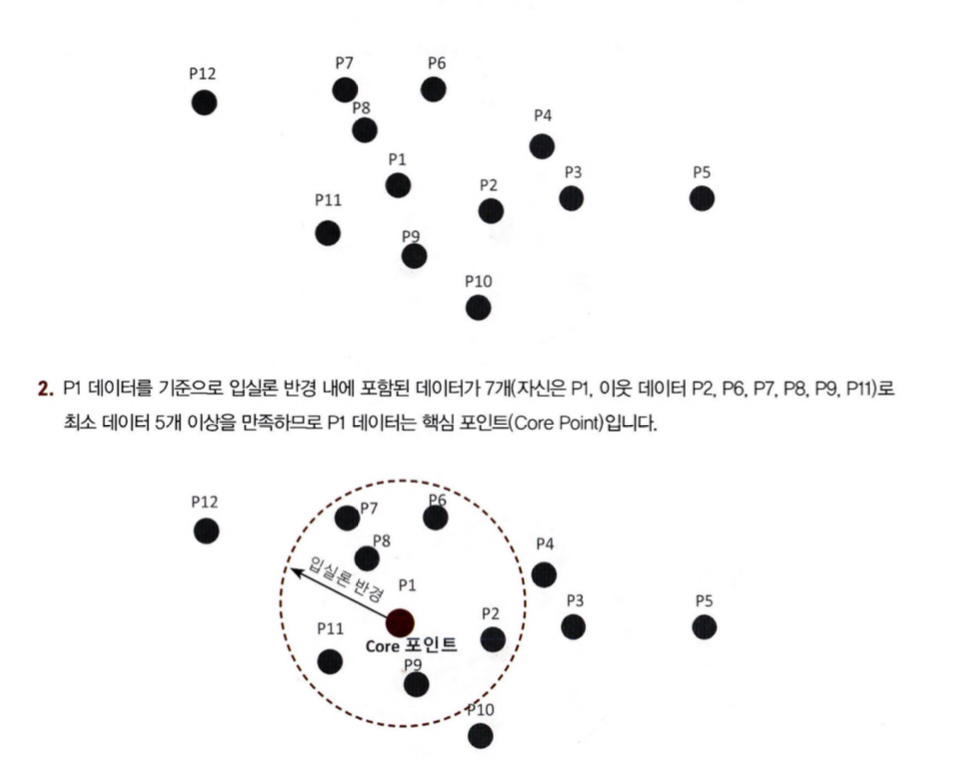

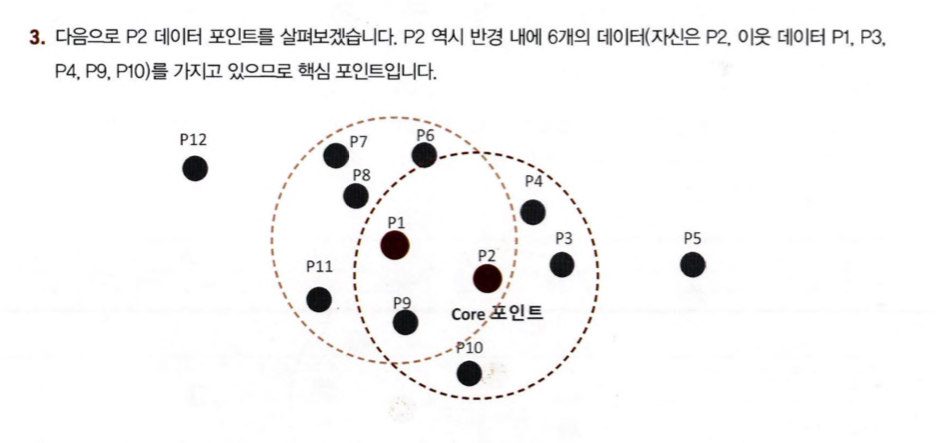

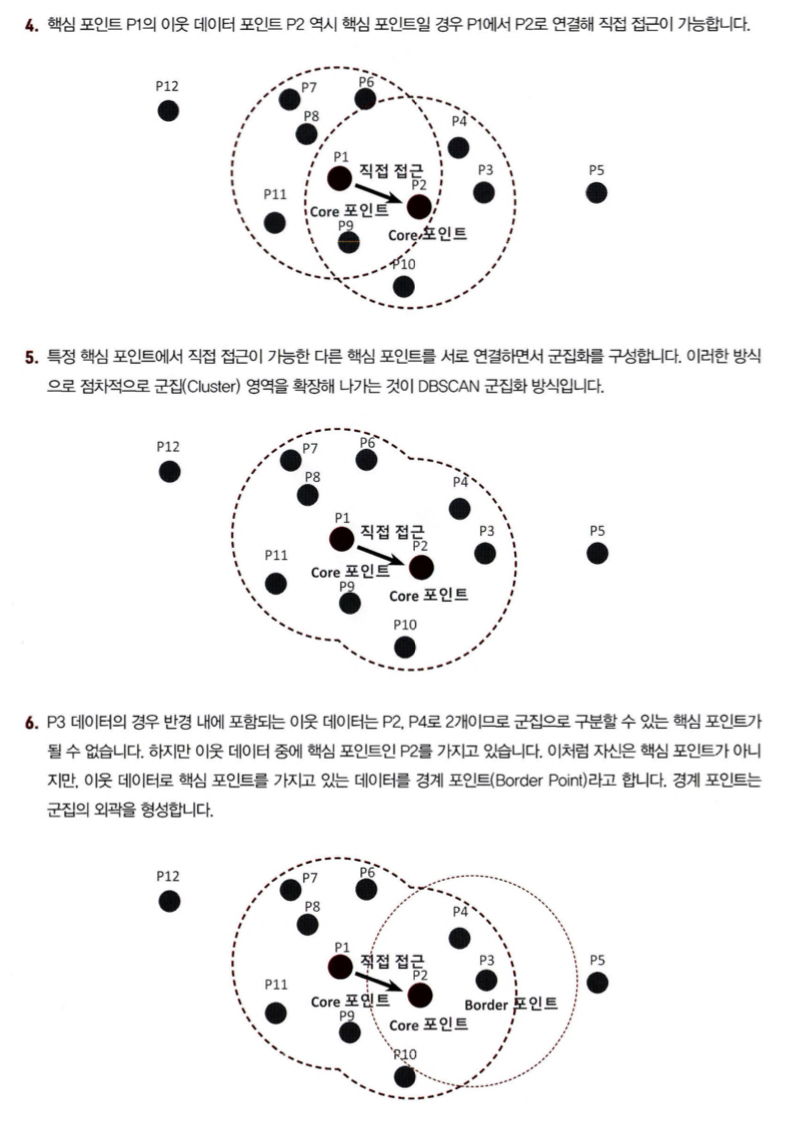

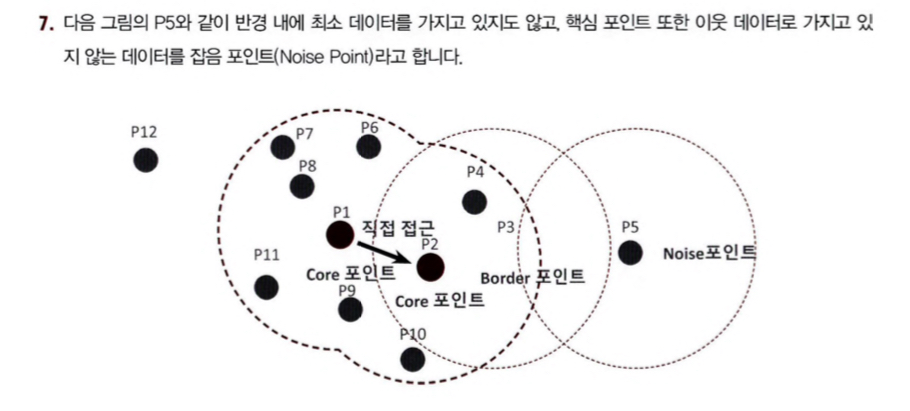

사이킷런 DBSCAN의 주요 파라미터

eps: 입실론 주변 영역의 반경 의미
min_samples: 핵심 포인트가 되기 위해 입실론 주변 영역 내에 포함돼야 할 데이터의 최소 개수를 의미 (자신 데이터 포함, min points + 1)

# DBSCAN 적용 - 붓꽃 데이터 세트

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
irisDF = pd.DataFrame(iris.data, columns=iris.feature_names)
irisDF['target'] = iris.target

from sklearn.cluster import DBSCAN

# 일반적으로 eps 값은 1 이하로 설정
dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)
irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
iris_result

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64

특이점: -1이 군집 레이블로 존재 -> 노이즈에 속하는 군집으로, 실질적으로 0과 1 두 개의 군집으로 군집화되었다고 볼 수 있음

target 값의 유형이 3개이지만 군집이 2개가 되었다고 효율이 떨어지는 것은 아님. DBSCAN은 군집의 개수를 알고리즘에 따라 자동으로 지정하므로 DBSCAN에서 군집의 개수를 지정하는 것은 무의미.

In [ ]:
# GMM에서 사용한 시각화 함수
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):

    # 군집별 중심 위치: K-Means, Mean Shift 등
    if iscenter:
        centers = clusterobj.cluster_centers_

    # Cluster 값 종류
    unique_labels = np.unique(dataframe[label_name].values)

    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        # 군집별 데이터 프레임
        label_cluster = dataframe[dataframe[label_name]==label]

        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else:
            cluster_legend = 'Cluster '+str(label)

        # 각 군집 시각화
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        # 군집별 중심 위치 시각화
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)

    if isNoise:
        legend_loc='upper center'
    else:
        legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

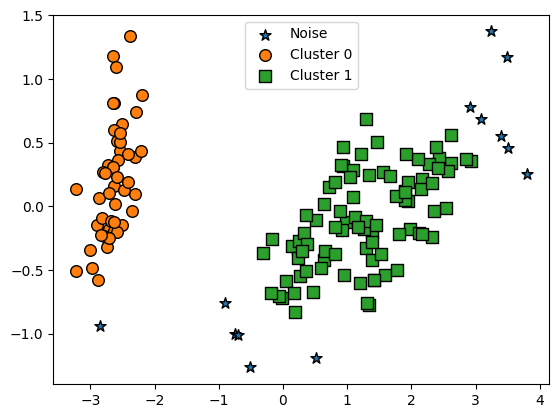

In [ ]:
from sklearn.decomposition import PCA
#2차원으로 시각화하기 위해 PCA n_components = 2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_plot() 함수는 ftr1, ftr2 칼럼을 좌표에 표현하므로 PCA 변환값을 해당 칼럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter = False)

별표는 모두 노이즈. PCA 이용해 데이터를 2차원으로 표현하면 이상치인 노이즈 데이터가 더 명확히 드러남.

DBSCAN 적용 시 특정 군집 개수로 군집 강제하기보다 알고리즘에 적절한 eps와 min_samples 파라미터를 통해 최적을 군집을 찾는 게 중요

eps 값을 크게 하면 반경이 커져 포함하는 데이터가 많아지고, 이에 따라 노이즈 데이터 개수가 작아짐. 반대로 min_samples를 크게 하면 주어진 반경 내에서 더 많은 데이터를 포함시켜야 하므로 노이즈 데이터 개수가 커지게 됨. 매우 촘촘한 데이터 분포가 아니면 노이즈로 인식하기 때문에.

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


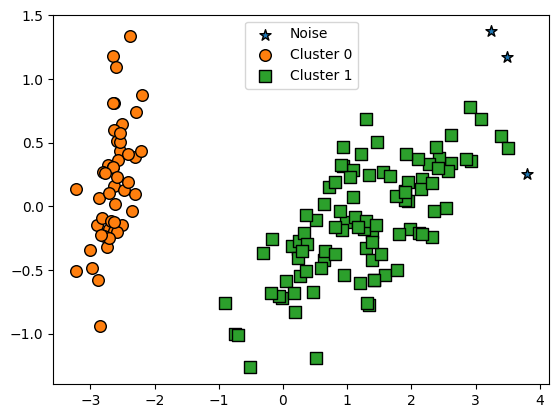

In [ ]:
from sklearn.cluster import DBSCAN

# eps를 0.6에서 0.8로 증가시켜 노이즈 수 줄이기
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

노이즈로 분류됐던 데이터가 eps 0.8로 반경이 커지면서 cluster 1에 소속됨

target  dbscan_cluster
0       -1                 2
         0                48
1       -1                 6
         1                44
2       -1                14
         1                36
dtype: int64


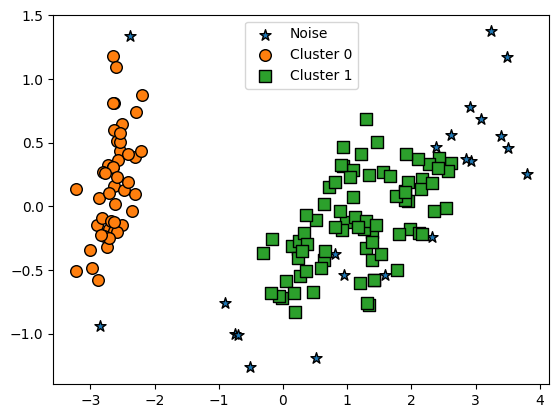

In [ ]:
# eps 0.6 유지, min_samples 늘리기
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(["target", "dbscan_cluster"]).size()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

노이즈가 처음보다 더 증가함

# DBSCAN 적용하기 - make_circles() 데이터 세트

복잡한 기하학적 분포를 가지는 데이터 세트에서 dbscan과 타 알고리즘 비교

make_circles(): 오직 2개의 피처만을 생성하므로 피처 개수를 지정할 필요 없음. 파라미터 noise는 노이즈 데이트 세트의 비율, factor는 외부 원과 내부 원이 scale 비율

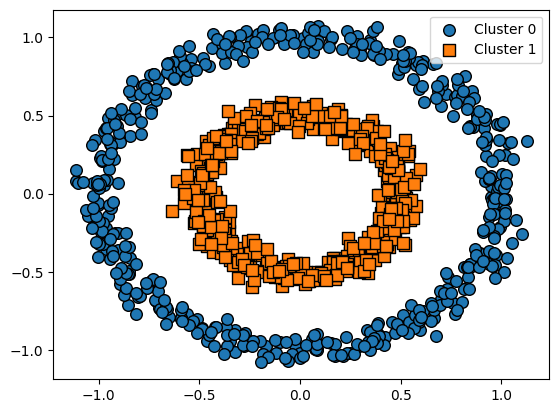

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

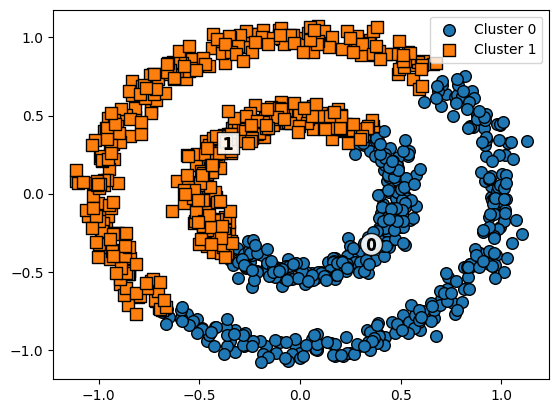

In [ ]:
# KMeans로 make_circle() 데이터 세트를 군집화 수행.
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

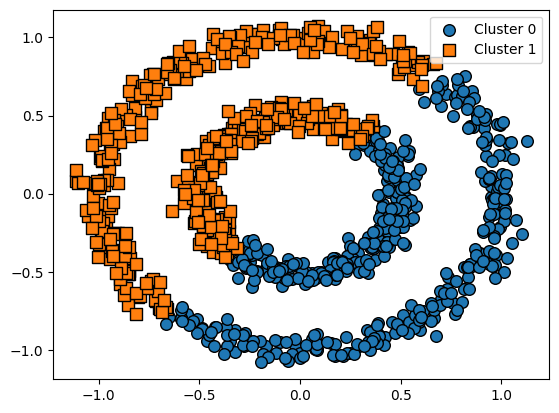

In [ ]:
# GMM으로 make_circle() 데이터 세트를 군집화 수행.
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

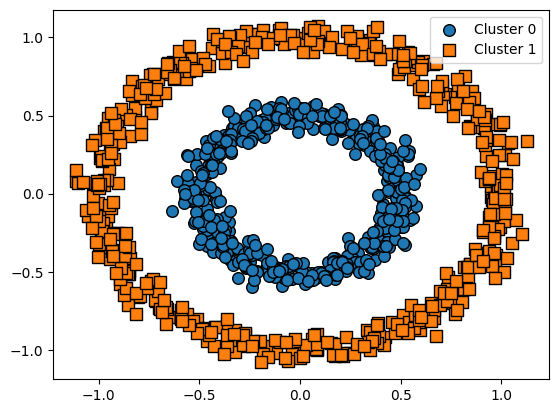

In [ ]:
# DBSCAN으로 make_circle() 데이터 세트 군집화 수행.
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

# 군집화 실습 - 고객 세그먼테이션

고객 세그먼테이션: 다양한 기준으로 고객을 분류하는 기법, CRM이나 마케팅의 중요한 요소

주요 목표는 타깃 마케팅으로, 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것.

In [ ]:
from io import IncrementalNewlineDecoder
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 제품 주문 데이터
retail_df = pd.read_excel('Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [ ]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


CustomerID의 Null값이 너무 으고, 다른 컬럼에도 오류 데이터 존재 -> 정제 작업 필요

In [ ]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
retail_df['Country'].value_counts()[:5]

,count
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484


In [ ]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


In [ ]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [ ]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

np.float64(1.028702077315023)

In [ ]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceData 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations = {
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'sale_amount':'Monetary'
}
)
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [ ]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는:', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는: (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


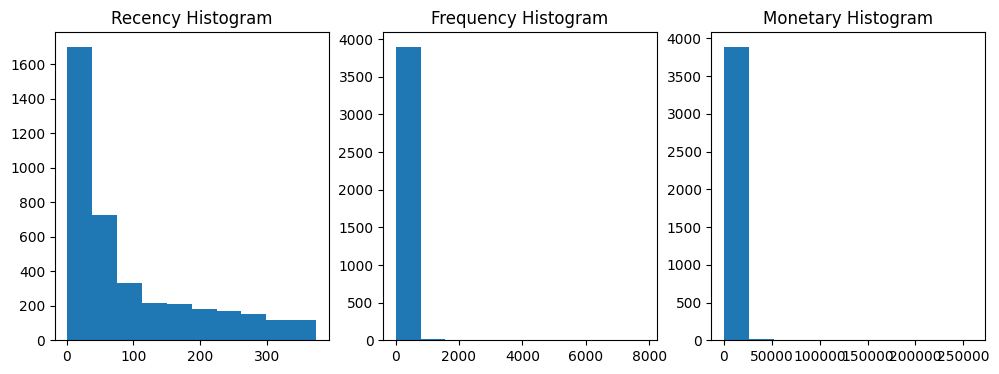

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows = 1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()

In [ ]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


왜곡 정도가 매우 높으므로, 변별력 떨어지는 군집화가 수행될 가능성 역시 높음. StandardScaler로 평균과 표준편차 재조정

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는: 0.576


In [ ]:
#군집 개수별로 군집화 구성을 시각화 하는 함수
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

In [ ]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

<ipython-input-33-2429430245>:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
<ipython-input-33-2429430245>:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


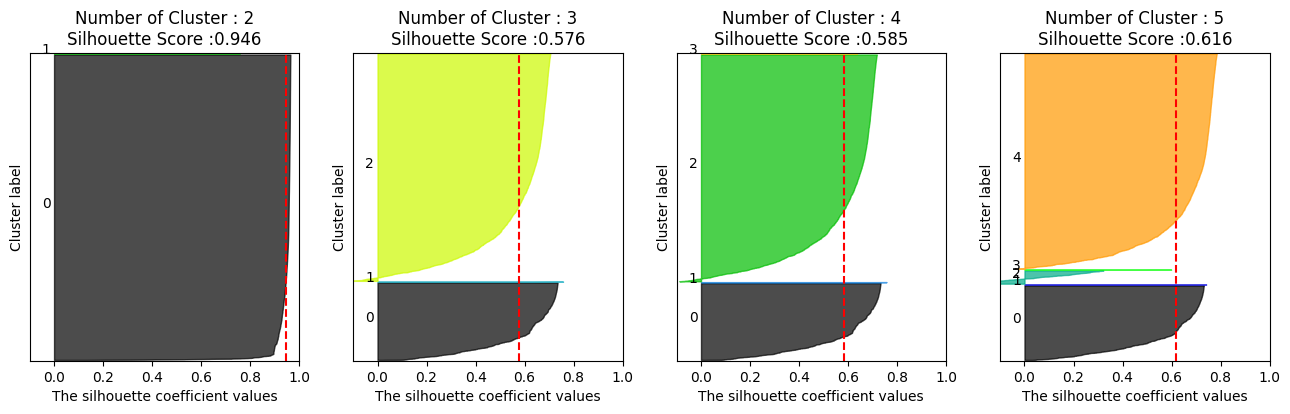

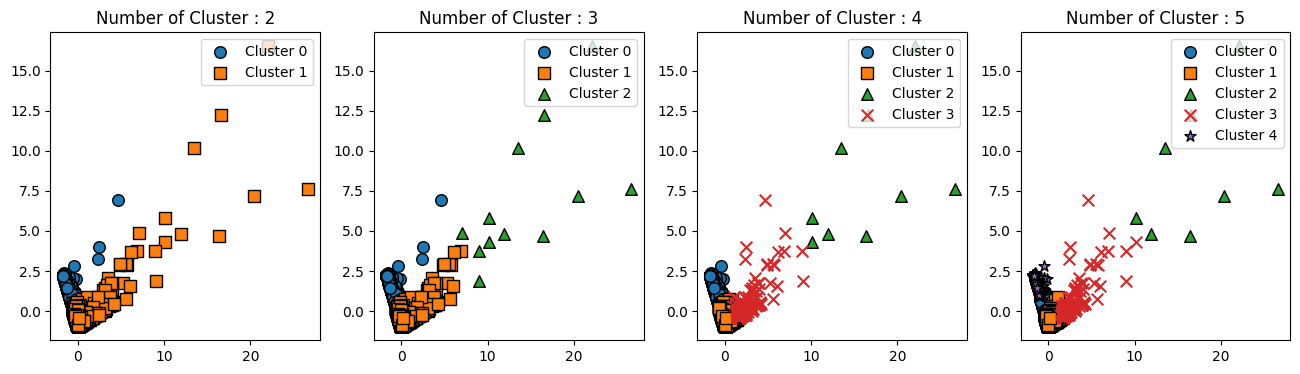

In [ ]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)

In [ ]:
cust_df['cluster_label'] = labels

print('실루엣 스코어는: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는: 0.303


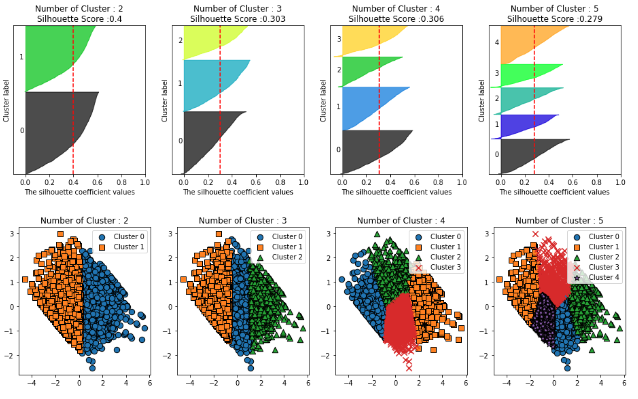